In [14]:
import SFALinearPulse as sfa_lin
import extra_packages.OutputInterface as inter
import extra_packages.sperhical_expansion as spex
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from itertools import repeat

In [15]:
import multiprocessing
#import ipyparallel as ipp

try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default

pool = multiprocessing.Pool(processes=cpus)

## The aim is to compare the GTOs with the asymptotic expansion
This is to see if we perhaps can just go with the asymptotoic expansion, as it would make life a lot easier when orientation averaging, since the spherical harmonics transform nicely under rotations.

## Get the coefficients for the GTO prefactor and set parameters

In [16]:
output = inter.OutputInterface('output_files/CHBrClF.out')
Ip = abs(output.saved_orbitals[output.HOMO][0])
kappa = np.sqrt(2*Ip)
omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential
CEP = np.pi/2
N = 2

gto_coeffs = np.array(output.output_GTOs())

## Obtain coefficients for asymptotic expansion

In [17]:
n_r = 50
n_l = 30
r_lst = np.linspace(1, 25, n_r)
f_lms = []
for i, r in enumerate(r_lst):
    print(f'Evaluating at r={r:.4f} \t Nr. {i+1}/{n_r}')
    f_lms.append(spex.spherical_expansion(lambda theta, phi: output.eval_orbital_spherical(r, theta, phi), 50))
f_lms = np.array(f_lms)

Evaluating at r=1.0000 	 Nr. 1/50
Evaluating at r=1.4898 	 Nr. 2/50
Evaluating at r=1.9796 	 Nr. 3/50
Evaluating at r=2.4694 	 Nr. 4/50
Evaluating at r=2.9592 	 Nr. 5/50
Evaluating at r=3.4490 	 Nr. 6/50
Evaluating at r=3.9388 	 Nr. 7/50
Evaluating at r=4.4286 	 Nr. 8/50
Evaluating at r=4.9184 	 Nr. 9/50
Evaluating at r=5.4082 	 Nr. 10/50
Evaluating at r=5.8980 	 Nr. 11/50
Evaluating at r=6.3878 	 Nr. 12/50
Evaluating at r=6.8776 	 Nr. 13/50
Evaluating at r=7.3673 	 Nr. 14/50
Evaluating at r=7.8571 	 Nr. 15/50
Evaluating at r=8.3469 	 Nr. 16/50
Evaluating at r=8.8367 	 Nr. 17/50
Evaluating at r=9.3265 	 Nr. 18/50
Evaluating at r=9.8163 	 Nr. 19/50
Evaluating at r=10.3061 	 Nr. 20/50
Evaluating at r=10.7959 	 Nr. 21/50
Evaluating at r=11.2857 	 Nr. 22/50
Evaluating at r=11.7755 	 Nr. 23/50
Evaluating at r=12.2653 	 Nr. 24/50
Evaluating at r=12.7551 	 Nr. 25/50
Evaluating at r=13.2449 	 Nr. 26/50
Evaluating at r=13.7347 	 Nr. 27/50
Evaluating at r=14.2245 	 Nr. 28/50
Evaluating at r=14.7

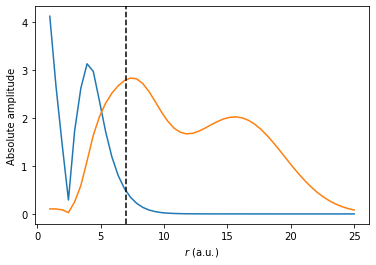

In [18]:
def radial(r):
    return r**(1/kappa - 1) * np.exp(-kappa*r)

plt.figure(facecolor='white')
sgn, l, m = 0, 1, 1
plt.plot(r_lst, np.abs(f_lms[:, sgn, l, m])*100)
plt.plot(r_lst, np.abs(f_lms[:, sgn, l, m]) / radial(r_lst))
plt.axvline(7, ls='--', color='k')                              # r = 7 seems like a solid choice!
plt.xlabel('$r$ (a.u.)')
plt.ylabel('Absolute amplitude')
plt.show()

In [19]:
clm_coeffs = spex.get_as_coeffs(output.eval_orbital_spherical, 7.0, 20, Ip, abs_thresh=1e-4)

## Calculate momentum distributions

In [20]:
dp = 4. / 100
px_lst = np.arange(-1, 1, dp)
pz_lst = np.arange(-1.5, 1.5, dp)
py = 0.
px_grd, pz_grd = np.meshgrid(px_lst, pz_lst)

# GTO
sfa_gto = sfa_lin.SFALinearPulse(Ip, Up, omega, N, CEP, 'GTO')
M_gto_grd = np.array(pool.starmap(sfa_gto.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(gto_coeffs))))
M_gto_sqr = np.abs(np.flip(M_gto_grd, 0))**2
print('GTO done!')

# Asymptotic
sfa_asymp = sfa_lin.SFALinearPulse(Ip, Up, omega, N, CEP, 'asymp_martiny')
M_asymp_grd = np.array(pool.starmap(sfa_asymp.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_coeffs))))
M_asymp_sqr = np.abs(np.flip(M_asymp_grd, 0))**2
print('Asymptotic done!')

GTO done!
Asymptotic done!


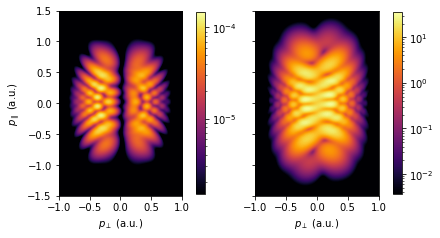

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='white', constrained_layout=True, sharey='all')

im1 = ax1.imshow(M_asymp_sqr, interpolation='bicubic', cmap='inferno',
                 norm=LogNorm(vmax=np.max(M_asymp_sqr), vmin=np.max(M_asymp_sqr)*1e-2),
                 extent=(-1, 1, -1.5, 1.5))
ax1.set_xlabel(r'$p_\perp$ (a.u.)')
ax1.set_ylabel(r'$p_\parallel$ (a.u.)')
plt.colorbar(im1, ax=ax1, shrink=0.65)

im2 = ax2.imshow(M_gto_sqr, interpolation='bicubic', cmap='inferno',
                 norm=LogNorm(vmax=np.max(M_gto_sqr), vmin=np.max(M_gto_sqr)*1e-4),
                 extent=(-1, 1, -1.5, 1.5))
ax2.set_xlabel(r'$p_\perp$ (a.u.)')
#ax2.set_ylabel(r'$p_\parallel$ (a.u.)')
plt.colorbar(im2, ax=ax2, shrink=0.65)

plt.show()